In [1]:
import xarray as xr
import numpy as np
import datetime
from scipy.ndimage import gaussian_filter

from meteoSI import mod_ad

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PlottingUtility import load_cbar_style, load_xy_style
from Utils import find_bases_tops
import Colormaps

_FIG_SIZE = (14, 4.7)

font_settings = {
    'range_interval': [0, 6000],
    'fig_size': [15, 10],
    'rg_converter': True,
    'font_size': 15,
    'font_weight': 'normal',
    'zlabel': '',
}


# trained on >100 epochs of 60/600 (20181127-20190927)
voodoo_nc = '20190801-20190801-20201017-174440__20201017-174440_weights_compressed.h5.nc'
case = voodoo_nc[:8]
YYYY, MM, DD = int(case[:4]), int(case[4:6]), int(case[6:8]) 


In [2]:
# open the dataset using xarray
voodoo_xr = xr.open_mfdataset(f'data/{voodoo_nc}')

# convert to datetime
dt_list = [datetime.datetime.fromtimestamp(ts) for ts in voodoo_xr.ts.values]
print(voodoo_xr)


# look at important classes "ice", "ice and supercooled droplets", "cloud droplets only", and "drizzle/rain"
P_mixed = voodoo_xr['voodoo_classification_probabilities'][:, :, 5].copy()
P_droplets = voodoo_xr['voodoo_classification_probabilities'][:, :, 1].copy()

# all classes containing cloud droplets
P_allCD = P_droplets.copy()
P_allCD.values = P_mixed.values + P_droplets.values


<xarray.Dataset>
Dimensions:                              (cl: 9, rg: 292, ts: 1081)
Coordinates:
  * ts                                   (ts) float64 1.565e+09 ... 1.565e+09
  * rg                                   (rg) float64 119.2 149.1 ... 1.196e+04
  * cl                                   (cl) int64 0 1 2 3 4 5 6 7 8
    temperature                          (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    pressure                             (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    target_classification                (ts, rg) int32 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    mask                                 (ts, rg) bool dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    lwp                                  (ts) float32 dask.array<shape=(1081,), chunksize=(1081,)>
Data variables:
    voodoo_classification_probabilities  (ts, rg, cl) float32 dask.array<shape=(1081, 292, 9), chunksize=(1081, 292, 9)>

# Smooth the predictions using a Gaussian filter


In [3]:

P_allCD.values = gaussian_filter(P_allCD.values, sigma=1.0)


# calculate adiabatic liquid water path from temperature and pressure profiles
calculate  liquid water path for cloud droplet containing pixel, if $P(\hat{y}=1 \wedge \hat{y}=5) > 0.7$, for a prediction $\hat{y} = \mathrm{voodoo}(\mathrm{X})$

In [4]:
                            
def calc_adLWP(liquid_mask, temperature, pressure, rg):

    bt_lists, bt_mask = find_bases_tops(liquid_mask, rg)
    adLWP = np.zeros(liquid_mask.shape[0])

    for iT in range(liquid_mask.shape[0]):
        
        n_cloud_layers = len(bt_lists[iT]['idx_cb'])
        if n_cloud_layers < 1: continue
        Tclouds, Pclouds, RHclouds, RGclouds = [], [], [], []

        lwc = 0
        for iL in range(n_cloud_layers):
            tmp_idx = np.arange(bt_lists[iT]['idx_cb'][iL], bt_lists[iT]['idx_ct'][iL], dtype=np.int)
            if tmp_idx.size > 1:  # exclude single range gate clouds
                
                lwc += np.sum(mod_ad(temperature[iT, tmp_idx], pressure[iT, tmp_idx], rg[tmp_idx]))   # kg/m3
                #print(f'range (iTime={iT}, iLayer={iL}) = {rg[tmp_idx]}')
                #print(f'lwc = {lwc}')

        # calculates adiabatic lwc
        lwc = lwc * 1000   # kg/m3 --> g/m3
        adLWP[iT] = np.sum(lwc)

    return adLWP


In [5]:
liquid_probability_threshold = 0.7
liquid_mask = P_allCD.values > liquid_probability_threshold

LWP = calc_adLWP(liquid_mask, voodoo_xr.temperature.values, voodoo_xr.pressure.values, voodoo_xr.rg.values)


# plot adiabatic lwp / MWR lwp and probability for cloud droplets


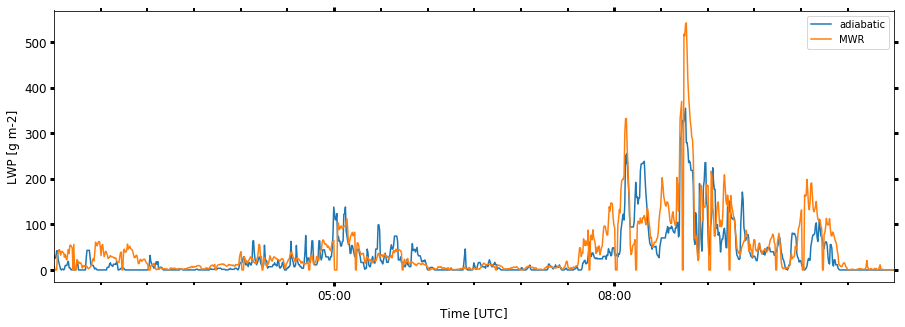

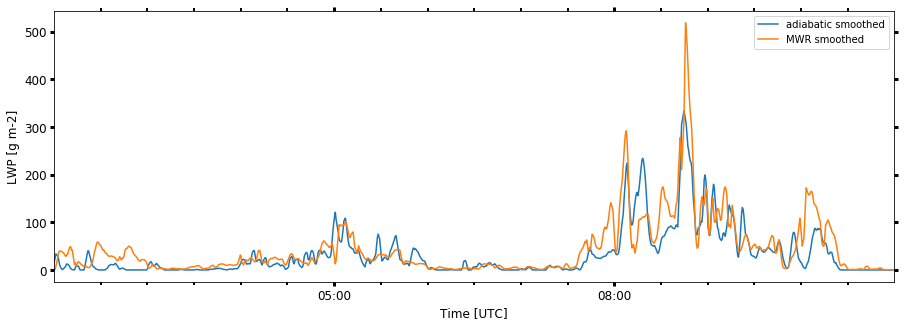

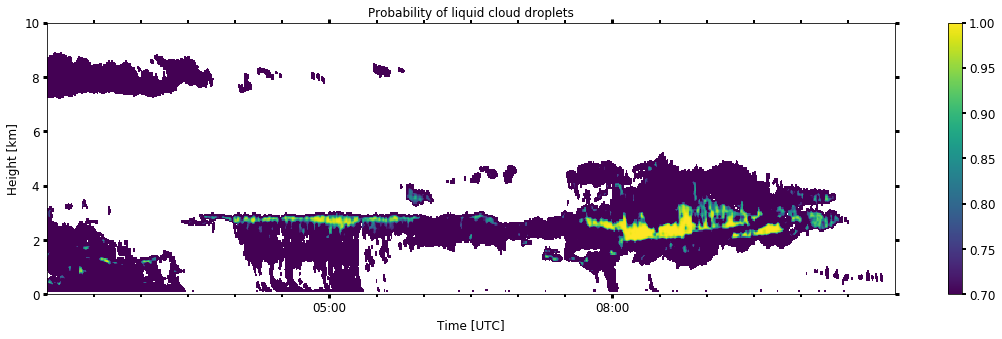

In [12]:
idk_factor = 50


box_pts = 5

box = np.ones(box_pts) / box_pts
X_smoothed = np.convolve(voodoo_xr.lwp.values, box, mode='same')
Y_smoothed = np.convolve(LWP, box, mode='same')

fig, ax = plt.subplots(ncols=1, figsize=(15.05, 5))
line = ax.plot(dt_list, LWP*idk_factor, label='adiabatic')
line = ax.plot(dt_list, voodoo_xr.lwp.values, label='MWR')
load_xy_style(ax, ylabel='LWP [g m-2]')
ax.set_xlim([dt_list[0], dt_list[-1]])
ax.legend()
fig.savefig(f'plots/{case}-MWR-VOODOO-lwp.png', dpi=450)


fig, ax = plt.subplots(ncols=1, figsize=(15.05, 5))
line = ax.plot(dt_list, Y_smoothed*idk_factor, label='adiabatic smoothed')
line = ax.plot(dt_list, X_smoothed, label='MWR smoothed')
load_xy_style(ax, ylabel='LWP [g m-2]')
ax.set_xlim([dt_list[0], dt_list[-1]])
ax.legend()
fig.savefig(f'plots/{case}-MWR-VOODOO-lwp-smoothed.png', dpi=450)

fig, ax = plt.subplots(ncols=1, figsize=(19., 5))
P_allCD.values = np.ma.masked_where(voodoo_xr.mask, P_allCD)
pmesh = ax.pcolormesh(dt_list, voodoo_xr.rg.values/1000., P_allCD.values.T, cmap='viridis', vmin=liquid_probability_threshold, vmax=1)
cbar = fig.colorbar(pmesh, ax=ax)
ax.set_ylim([0, 10])
ax.set_title(f'Probability of liquid cloud droplets')
load_xy_style(ax, ylabel='Height [km]')
load_cbar_style(cbar)
fig.savefig(f'plots/{case}-liquid-cloud-doplet-probability.png', dpi=450)


In [7]:

corr = np.ma.corrcoef(np.ma.masked_less_equal(voodoo_xr.lwp.values, 0.0), np.ma.masked_less_equal(LWP, 0.0))[0, 1]
corr_smoothed = np.ma.corrcoef(np.ma.masked_less_equal(X_smoothed, 0.0), np.ma.masked_less_equal(Y_smoothed, 0.0))[0, 1]

print(f'      correlation raw prediction = {corr:.2f}')
print(f'correlation smoothed predicitons = {corr_smoothed:.2f}')
print(f' maximum liquid water path value = {LWP.max():.2f} [g m-2]') 


      correlation raw prediction = 0.80
correlation smoothed predicitons = 0.82
 maximum liquid water path value = 7.09 [g m-2]
